In [12]:
from walidacja_funkcji import *
from nf import *
import torch
import torch.nn as nn
import torch.optim as optim
from scipy import stats

100.0%

/home/mamusiaarusia/praktyki/nf.py:129: RuntimeWarning: invalid value encountered in log10
  plt.plot(np.log10(loss_history), 'o', markersize=0.3)


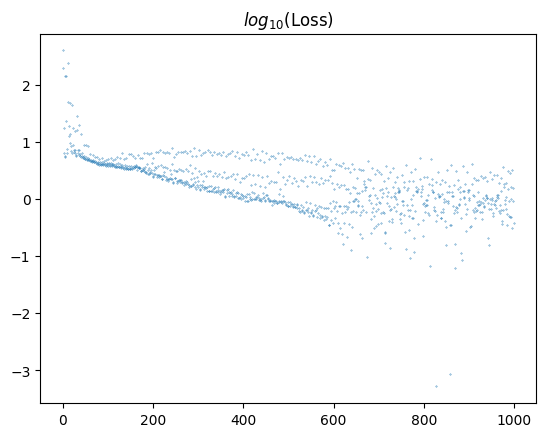

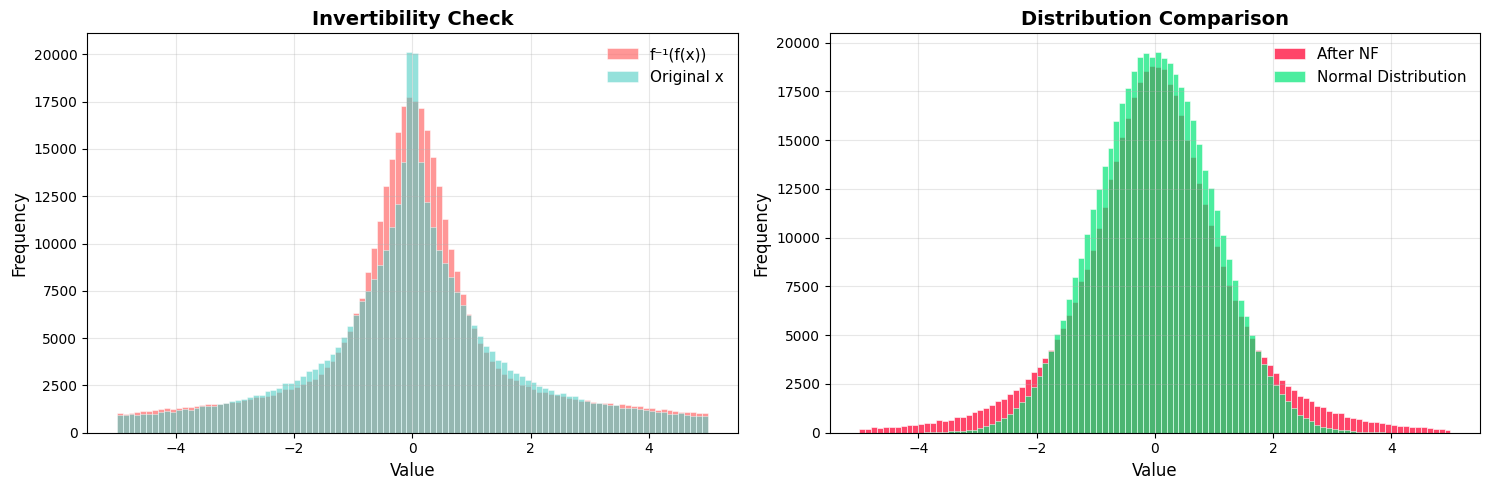

100.0%

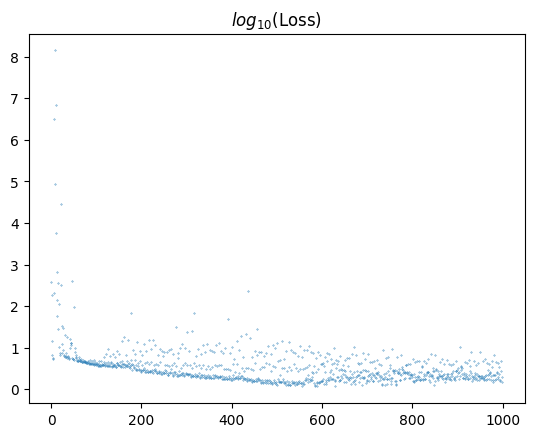

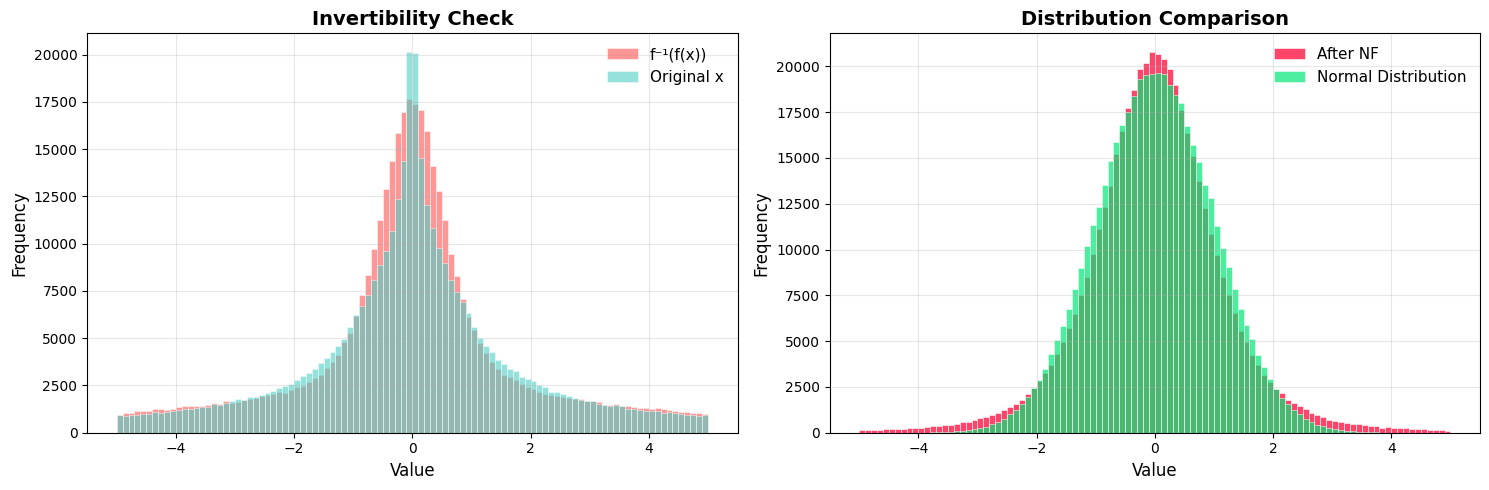

In [44]:
x_transform = NF(6, GENERATOR_SAMPLES_TO_RETURN // 4, 1e-3)
y_transform = NF(6, GENERATOR_SAMPLES_TO_RETURN // 4, 1e-3) # po uczeniu obydwa modele powinny byc ustawione na eval

learn_nf(x_transform, GENERATOR_SAMPLES_TO_RETURN, BATCH_SIZE, 1000, 0)
learn_nf(y_transform, GENERATOR_SAMPLES_TO_RETURN, BATCH_SIZE, 1000, 0)

def transform_to_normal(input):
    input = input.reshape(BATCH_SIZE, -1, 2)
    x, y = input[:, :, 0], input[:, :, 1]
    x, y = x_transform.forward(x), y_transform.forward(y)
    input = torch.cat([x, y], dim=1)

def transform_to_NKG(input):
    input = input.reshape(BATCH_SIZE, -1, 2)
    x, y = input[:, :, 0], input[:, :, 1]
    x, y = x_transform.inverse(x), y_transform.inverse(y)
    input = torch.cat([x, y], dim=1)

In [45]:
def reinit_model(model):
    """Reinicjalizuje wagi modelu"""
    for layer in model.modules():
        if isinstance(layer, nn.Linear):
            nn.init.xavier_uniform_(layer.weight)
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)

def fast_kl_jsd_2d(real_data, fake_data, bins=50):
    all_data = np.vstack([real_data, fake_data])
    range_2d = [(all_data[:, i].min(), all_data[:, i].max()) for i in range(all_data.shape[1])]
    
    # Histogramy w jednej operacji
    P, _ = np.histogramdd(real_data, bins=bins, range=range_2d, density=True)
    Q, _ = np.histogramdd(fake_data, bins=bins, range=range_2d, density=True)
    
    # Normalizacja do prawdopodobieństw
    P = P / P.sum()
    Q = Q / Q.sum()
    
    # Epsilon dla stabilności numerycznej
    epsilon = 1e-8
    P += epsilon
    Q += epsilon
    
    # KL divergence: KL(Q||P) - fake vs real
    kl_divergence = np.sum(Q * np.log(Q / P))
    
    # JSD: 0.5 * [KL(P||M) + KL(Q||M)], gdzie M = (P+Q)/2
    M = (P + Q) / 2 + epsilon
    
    kl_pm = np.sum(P * np.log(P / M))
    kl_qm = np.sum(Q * np.log(Q / M))
    jsd = 0.5 * (kl_pm + kl_qm)
    
    return kl_divergence, jsd

In [68]:
def plot_basic_stats(generator_losses, discriminator_losses, KL, JSD, Wasserstein_distance, epoch, extra_label=''):
    # plt.ioff()
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(15, 15))
    SAMPLE_LENGTH = GENERATOR_SAMPLES_TO_RETURN * 10000
    ROI = np.array([[-5, 5], [-5, 5]])
    epoch_range = np.arange(epoch)
    markersize = min(2000 / len(epoch_range), 10)
    
    gen_color = '#1f77b4'     # Matplotlib blue
    disc_color = '#d62728'    # Matplotlib red
    x_color = '#ff7f0e'       # Matplotlib orange
    y_color = '#2ca02c'       # Matplotlib green
    theory = '#9467bd'        # Matplotlib purple

    # Get data
    data = get_2d_data(SAMPLE_LENGTH)
    x_true, y_true = data[:, 0], data[:, 1]
    noise = torch.randn(SAMPLE_LENGTH // GENERATOR_SAMPLES_TO_RETURN, NOISE_SIZE).cuda()
    x_fake, y_fake = generator.layers(noise).detach().reshape(-1, 2).cpu().numpy().T

    # Histograms
    hist_true, _, _ = np.histogram2d(x_true, y_true, bins=500, range=ROI)
    hist_fake, _, _ = np.histogram2d(x_fake, y_fake, bins=500, range=ROI)
    
    # Plot 1-2: 2D histograms
    for ax, hist, title in [(ax1, hist_fake, 'Generatora'), (ax2, hist_true, 'NKG rejection sampling')]:
        im = ax.imshow(np.log10(hist + 1).T, extent=ROI.flatten(), aspect='auto')
        ax.set_title(f'$log_{{10}}$(Liczby czastek)\n Rozklad dla {title}')
        ax.set_xlabel('x [m]')
        ax.set_ylabel('y [m]')
        plt.colorbar(im, ax=ax)

    # Plot 3: Losses
    ax3.set_title(f'Logarytm strat, lr_gen={generator.optim.param_groups[0]["lr"]:.2e}\n lr_dis={discriminator.optim.param_groups[0]["lr"]:.2e}')
    ax3.plot(epoch_range, np.log10(discriminator_losses[:epoch] + 1e-12), 'o', markersize=markersize, label='dyskryminator', color=disc_color)
    ax3.plot(epoch_range, np.log10(generator_losses[:epoch] + 1e-12), 'o', markersize=markersize, label='generator', color=gen_color)
    ax3.legend(markerscale=1.5/markersize)
    ax3.set_xlabel('Epoka')
    ax3.set_ylabel(r'$log_{10}$(strata)')
    
    # Plot 4: KL, JSD, Wasserstein
    ax4.set_title('Metryki rozbieznosci')
    ax4.plot(epoch_range, np.log10(Wasserstein_distance[:epoch] + 1e-12), 'o', markersize=markersize, color='green', label='Wasserstein')
    ax4.plot(epoch_range, np.log10(KL[:epoch] + 1e-12), 'o', markersize=markersize, color='blue', label='KL')
    ax4_twin = ax4.twinx()
    ax4_twin.plot(epoch_range, np.log10(JSD[:epoch] + 1e-12), 'o', markersize=markersize, color='red', label='JSD')
    ax4.set_ylabel('$log_{10}$(KL, Wasserstein)', color='blue')
    ax4_twin.set_ylabel('$log_{10}$(JSD)', color='red')
    ax4.set_xlabel('Epoka')
    ax4.legend(markerscale=1.5/markersize, loc='upper left')
    ax4_twin.legend(markerscale=1.5/markersize, loc='upper right')

    # Plot 5: R distribution
    r_true, r_fake = np.sqrt(x_true**2 + y_true**2), np.sqrt(x_fake**2 + y_fake**2)
    r_bins = np.linspace(r_true.min(), r_true.max(), 100)
    ax5.hist(r_true, bins=r_bins, label='Rejection sampling', color=theory, alpha=0.7, edgecolor='white', linewidth=0.5)
    ax5.hist(r_fake, bins=r_bins, label='Generator', alpha=0.6, color=gen_color, edgecolor='white', linewidth=0.5)
    ax5.set_title('Rozklad r')
    ax5.set_xlabel('r [m]')
    ax5.set_ylabel('Liczba probek')
    ax5.legend()

    # Plot 6: X,Y distributions
    bins = np.linspace(-5, 5, 100)
    ax6.hist(x_fake, bins=bins, label=r'$x_{Fake}$', alpha=0.95, color=x_color, edgecolor='white', linewidth=0.5)
    ax6.hist(y_fake, bins=bins, label=r'$y_{Fake}$', alpha=0.80, color=y_color, edgecolor='white', linewidth=0.5)
    ax6.hist(x_true, bins=bins, label=r'$x_{True}$', alpha=0.65, color=theory, edgecolor='white', linewidth=0.5)
    ax6.hist(y_true, bins=bins, label=r'$y_{True}$', alpha=0.25, color='#8B4513', edgecolor='white', linewidth=0.5)  # Saddle Brown zamiast czarnego
    ax6.set_xlabel('Wartosc wspolrzednej x lub y')
    ax6.set_ylabel('Liczba probek')
    ax6.set_title('Rozklady wspolrzednych')
    ax6.legend()

    # Plot 7: standard deviation
    ax7.set_title('Odchyelnie standardowe')
    ax7.plot(epoch_range, x_stdev_history[:epoch], 'o', markersize=markersize, label=r'$\sigma_x$')
    ax7.plot(epoch_range, y_stdev_history[:epoch], 'o', markersize=markersize, label=r'$\sigma_x$')
    ax7.plot([0, epoch], [np.std(x_true)] * 2, '--', label=r'Teoretyczna wartosc')
    ax7.set_xlabel('Epoka')
    ax7.set_ylabel(r'$\sigma$')
    ax7.legend()

    # Plot 8: means
    ax8.set_title('Wartosc oczekiwana')
    ax8.plot(epoch_range, x2_mean_history[:epoch], 'o', markersize=markersize, label=r'E[$x^2$]')
    ax8.plot(epoch_range, y2_mean_history[:epoch], 'o', markersize=markersize, label=r'E[$y^2$]')
    ax8.plot([0, epoch], [np.std(x_true)] * 2, '--', label=r'Teoretyczna wartosc')
    ax8.set_xlabel('Epoka')
    ax8.set_ylabel(r'Wartosc')
    ax8.legend()
    
    # Plot 9: Zmiany wag
    ax9.set_title('Zmiana wagi')
    ax9.plot(epoch_range, G_weight_change[:epoch], 'o', markersize=markersize, label=r'Na generatorze', color=gen_color)
    ax9.plot(epoch_range, D_weight_change[:epoch], 'o', markersize=markersize, label=r'Na dyskryminatorze', color=disc_color)
    ax9.set_xlabel('Epoka')
    ax9.set_ylabel(r'Wartosc')
    ax9.legend()

    # Statistics
    r_pearson = np.log10(1 - np.corrcoef(np.sort(r_true), np.sort(r_fake))[0, 1])
    x_pearson = np.log10(1 - np.corrcoef(np.sort(x_true), np.sort(x_fake))[0, 1])
    y_pearson = np.log10(1 - np.corrcoef(np.sort(y_true), np.sort(y_fake))[0, 1])

    # Fixed text positioning - move higher to avoid cutting
    fig.text(0.5, 0.97, f'{EPOCHS=}, {LR_CONSTANT=}, {LR_RATIO=}, {BATCH_SIZE=}', ha='center', fontsize=16)
    fig.text(0.5, 0.945, f'{GENERATOR_SAMPLES_TO_RETURN=}, {NOISE_SIZE=}', ha='center', fontsize=16)
    fig.text(0.5, 0.92, rf'$log_{{10}}$(1-$\rho_{{r, Pearson}}$) = {r_pearson:.3f}, $log_{{10}}$(1-$\rho_{{x, Pearson}}$) = {x_pearson:.3f}, $log_{{10}}$(1-$\rho_{{y, Pearson}}$) = {y_pearson:.3f}', ha='center', fontsize=16)
    
    # Adjust layout with proper spacing for text
    plt.tight_layout(rect=[0, 0.02, 1, 0.91])  # Leave more space at top
    plt.savefig(f'./Wykresy/Moj_NKG/podsumowanie{extra_label}.jpg', dpi=150, bbox_inches='tight')
    # plt.show()
    # plt.close()

In [69]:
class ResidualBlock(nn.Module): # bardzo niewiele one daja
    def __init__(self, layers: list):
        """
            Assuming input and output are 1d
        """
        super(ResidualBlock, self).__init__()
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        identity = x
        x = x.unsqueeze(1)
        layers_output = self.layers(x)
        return layers_output + identity

In [70]:
"""
    Generator z szumu bedzie dawac x i y - ale czy ja powinienem mu przeslac informacje o zakresie w jakim ma generowac x ?
"""

class Generator(nn.Module):
    def __init__(self, layers: list, lr: float = 1e-5):
        super().__init__()
        self.layers = nn.Sequential(*layers)
        self.optim = optim.RMSprop(self.parameters(), lr)
        self.loss = nn.MSELoss()
        self.to('cuda')

    # def loss(self, fake_data):
    #     return -torch.mean(fake_data)

    def training_step(self, noise, true_data): # OPTIMIZE - would be nice to send here the data - instead of generating it
        self.zero_grad()
        fake_data = generator.layers(noise)

        transform_to_normal(fake_data)

        fake_labels = discriminator.layers(fake_data)
        
        # fake_squared_means = torch.pow(fake_data, 2).mean(dim=1, keepdim=True)
        # true_squared_means = torch.pow(true_data, 2).mean(dim=1, keepdim=True) # to jest stala on pewnie te wagi przez ta stala normalizuje

        # penalization1 = self.loss(fake_squared_means, true_squared_means)
        mse_loss = self.loss(fake_labels, torch.ones_like(fake_labels))

        gen_loss = mse_loss # + penalization1 # MSELoss bedzie w skali [0, 1] chce tego samego od penalizatora
        gen_loss.backward()
        
        gen_loss = gen_loss.detach().cpu().item()
        # torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=5.0)

        self.optim.step()
        
        return mse_loss #, penalization1

In [61]:
"""
    Dyskriminator tak jak zwykle bierze input i zwraca czy prawdziwy czy nie
"""

class Discriminator(nn.Module):
    def __init__(self, layers: list, lr: float = 1e-5):
        super().__init__()
        self.layers = nn.Sequential(*layers)
        self.optim = optim.Adam(self.parameters(), lr)
        self.loss = nn.MSELoss()
        self.to('cuda')

    # def loss(self, D_real, D_fake):
    #     loss_real = torch.mean(torch.relu(1.0 - D_real))
    #     loss_fake = torch.mean(torch.relu(1.0 + D_fake))
    #     return loss_real + loss_fake

    def training_step(self, true_data, fake_data, steps = 1):
        for _ in range(steps):
            self.optim.zero_grad()

            y_true = self.layers(true_data)
            loss_true = self.loss(y_true, torch.ones_like(y_true).cuda())
            
            y_fake = self.layers(fake_data)
            loss_fake = self.loss(y_fake, torch.zeros_like(y_fake).cuda())
            
            loss = (loss_true + loss_fake)
            loss.backward()
            loss = loss.detach().item()

            self.optim.step()
            
        return loss

Trening [████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████] 9999/10000
(100.0%)

2086 Epok / min


ValueError: too many values to unpack (expected 2)

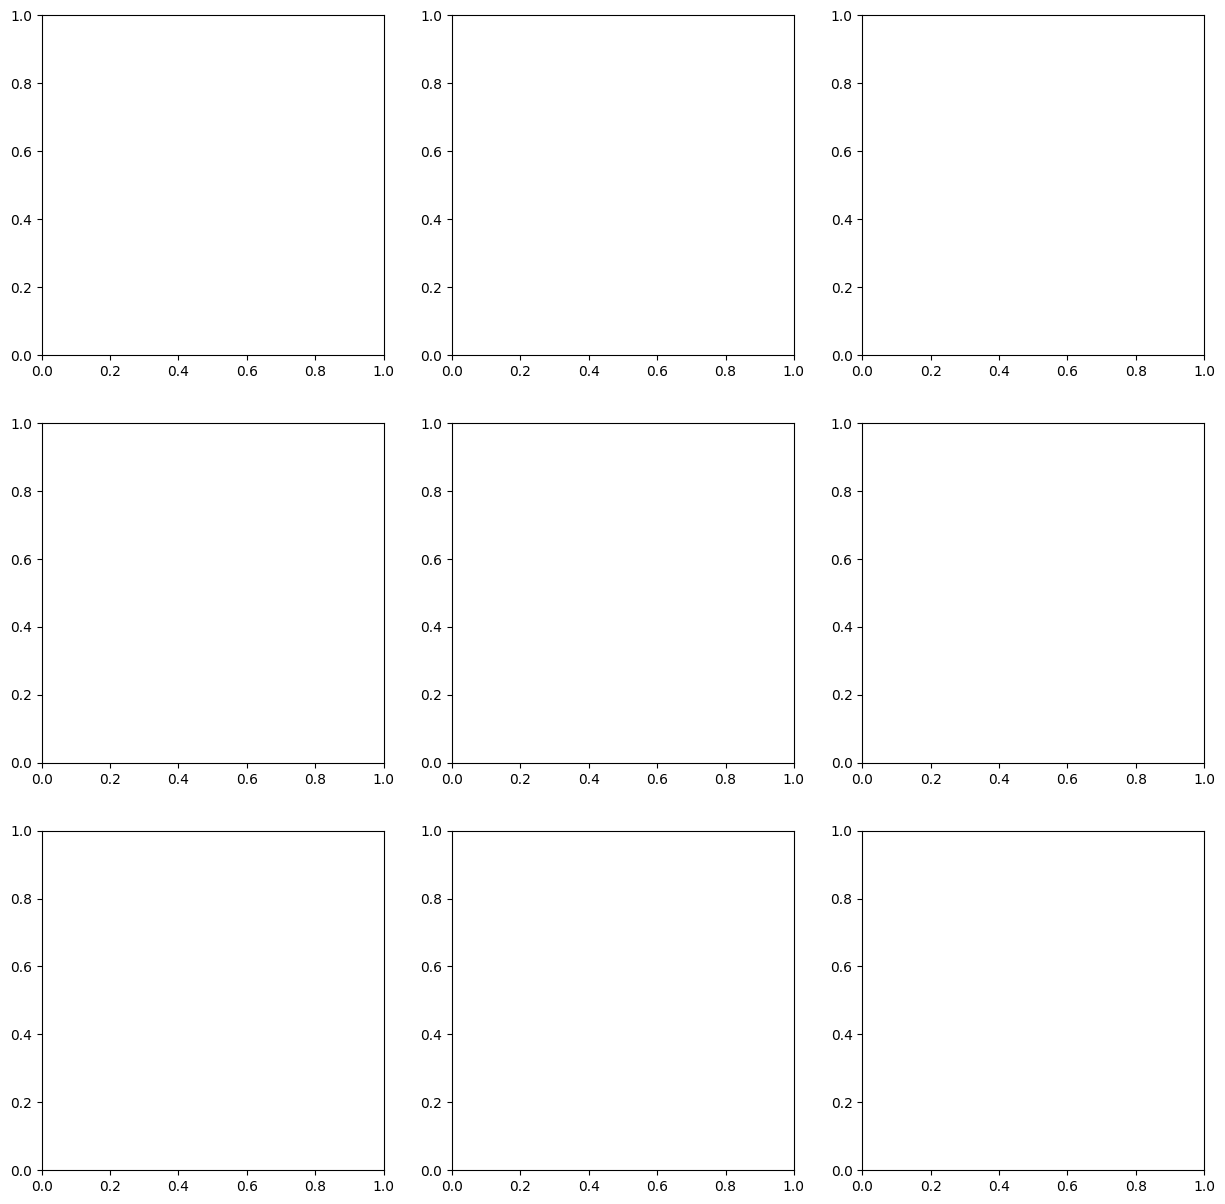

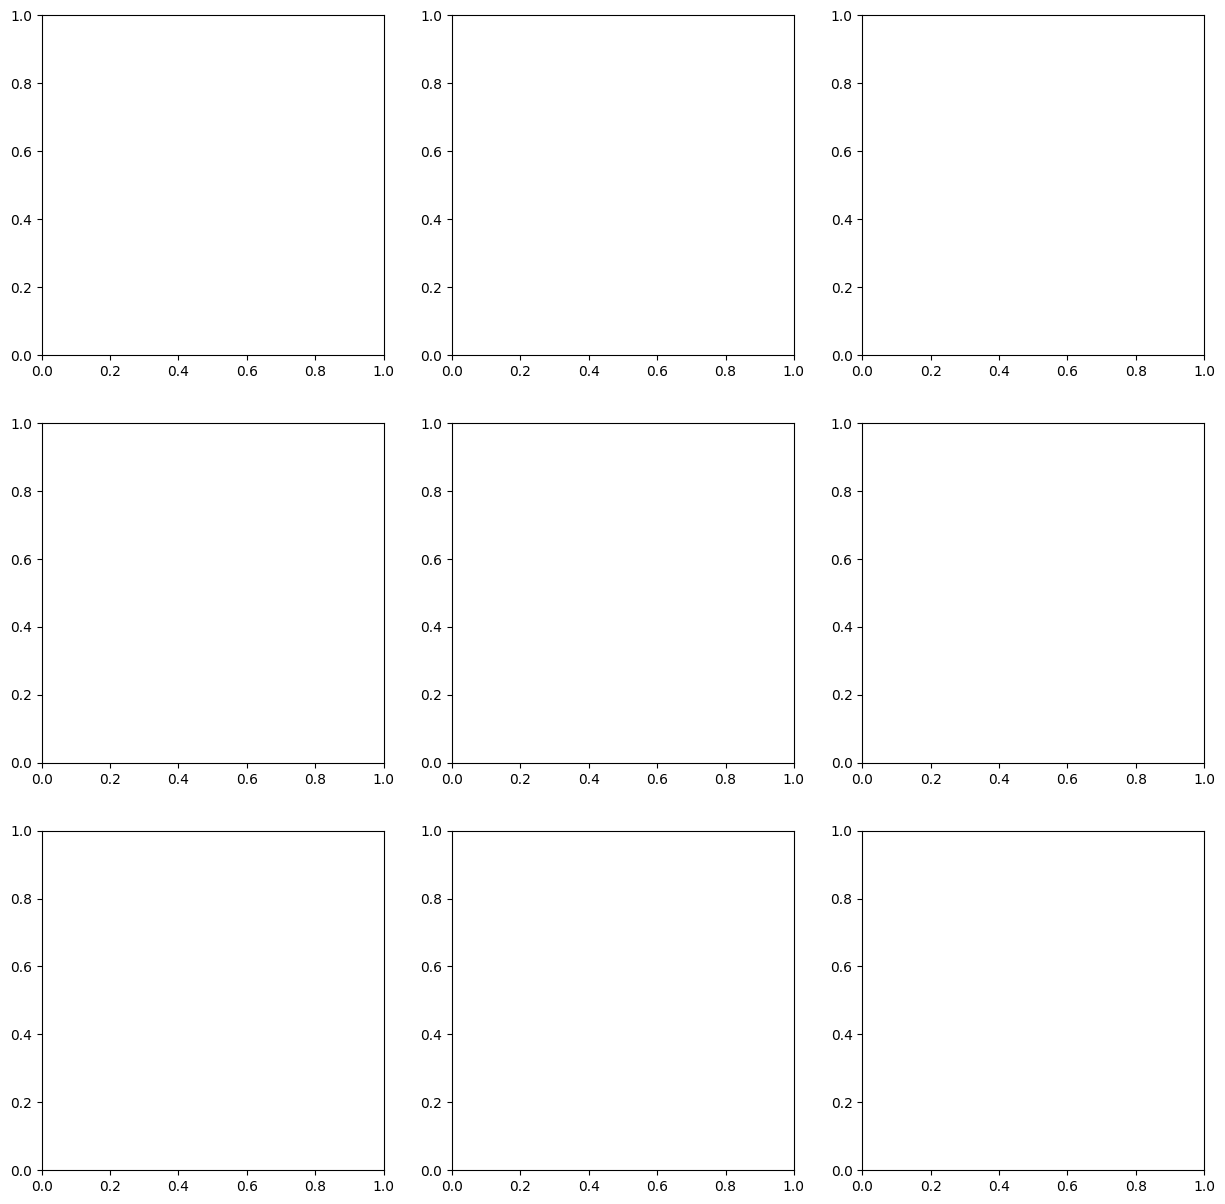

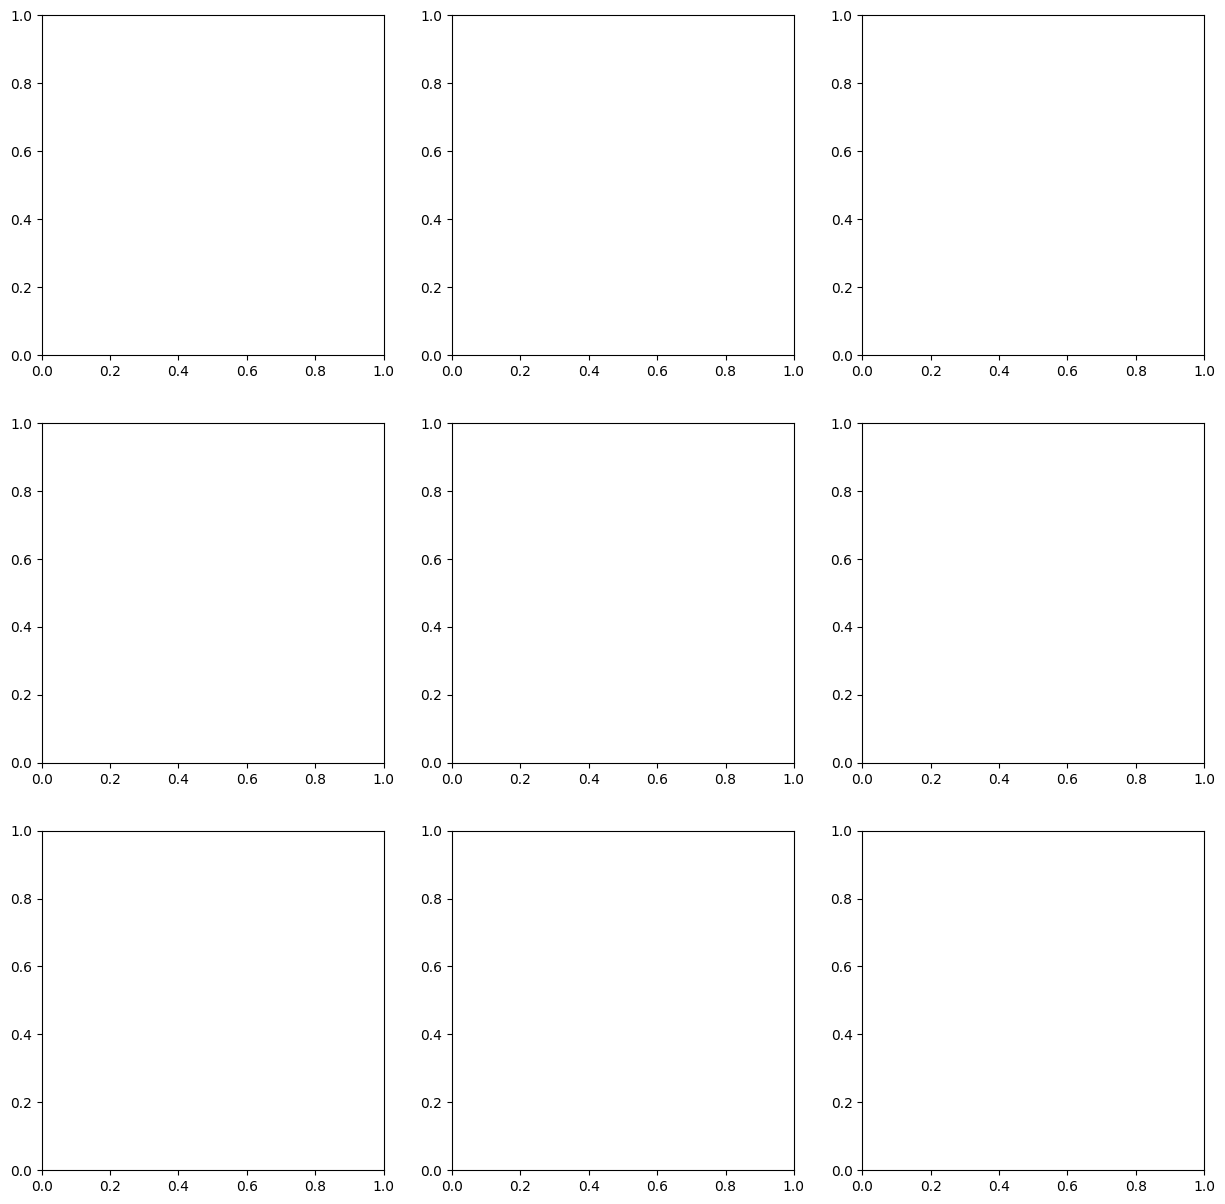

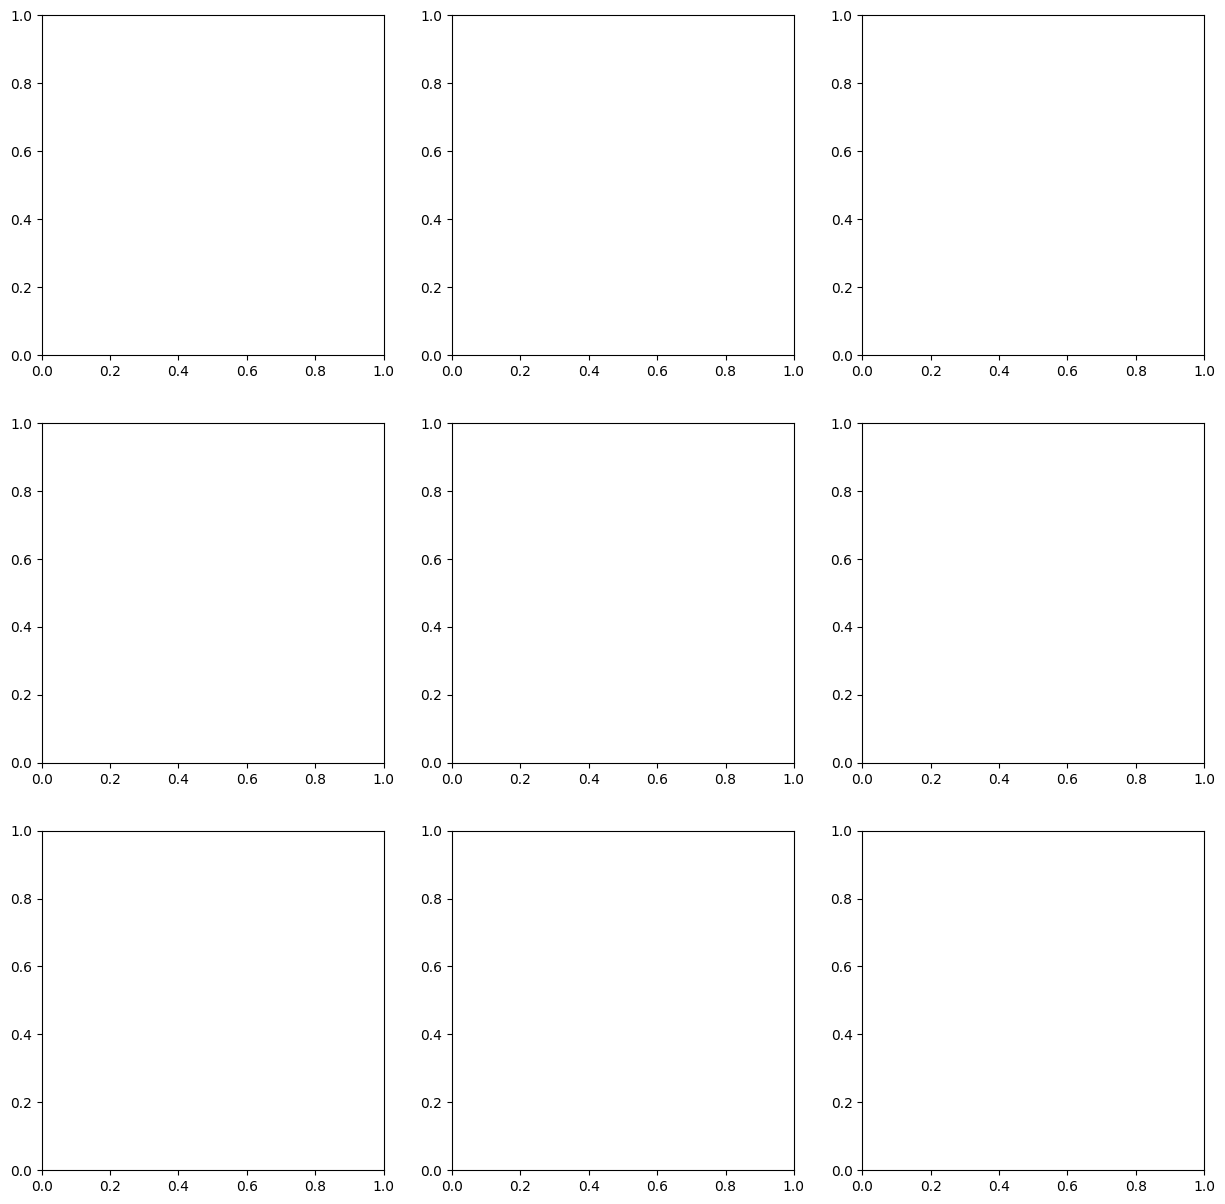

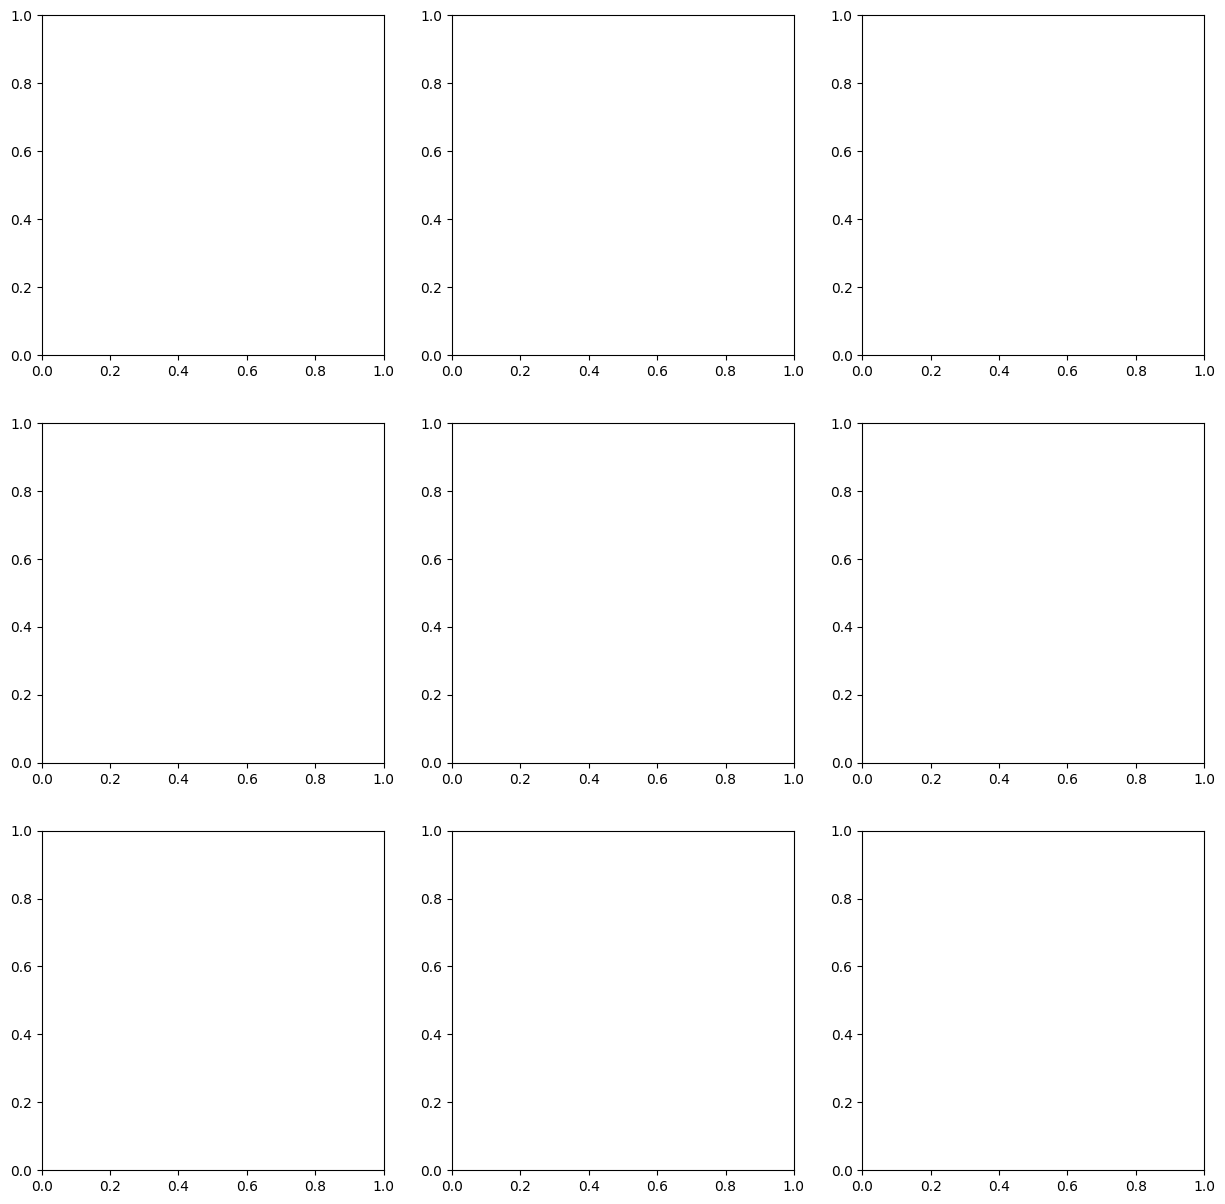

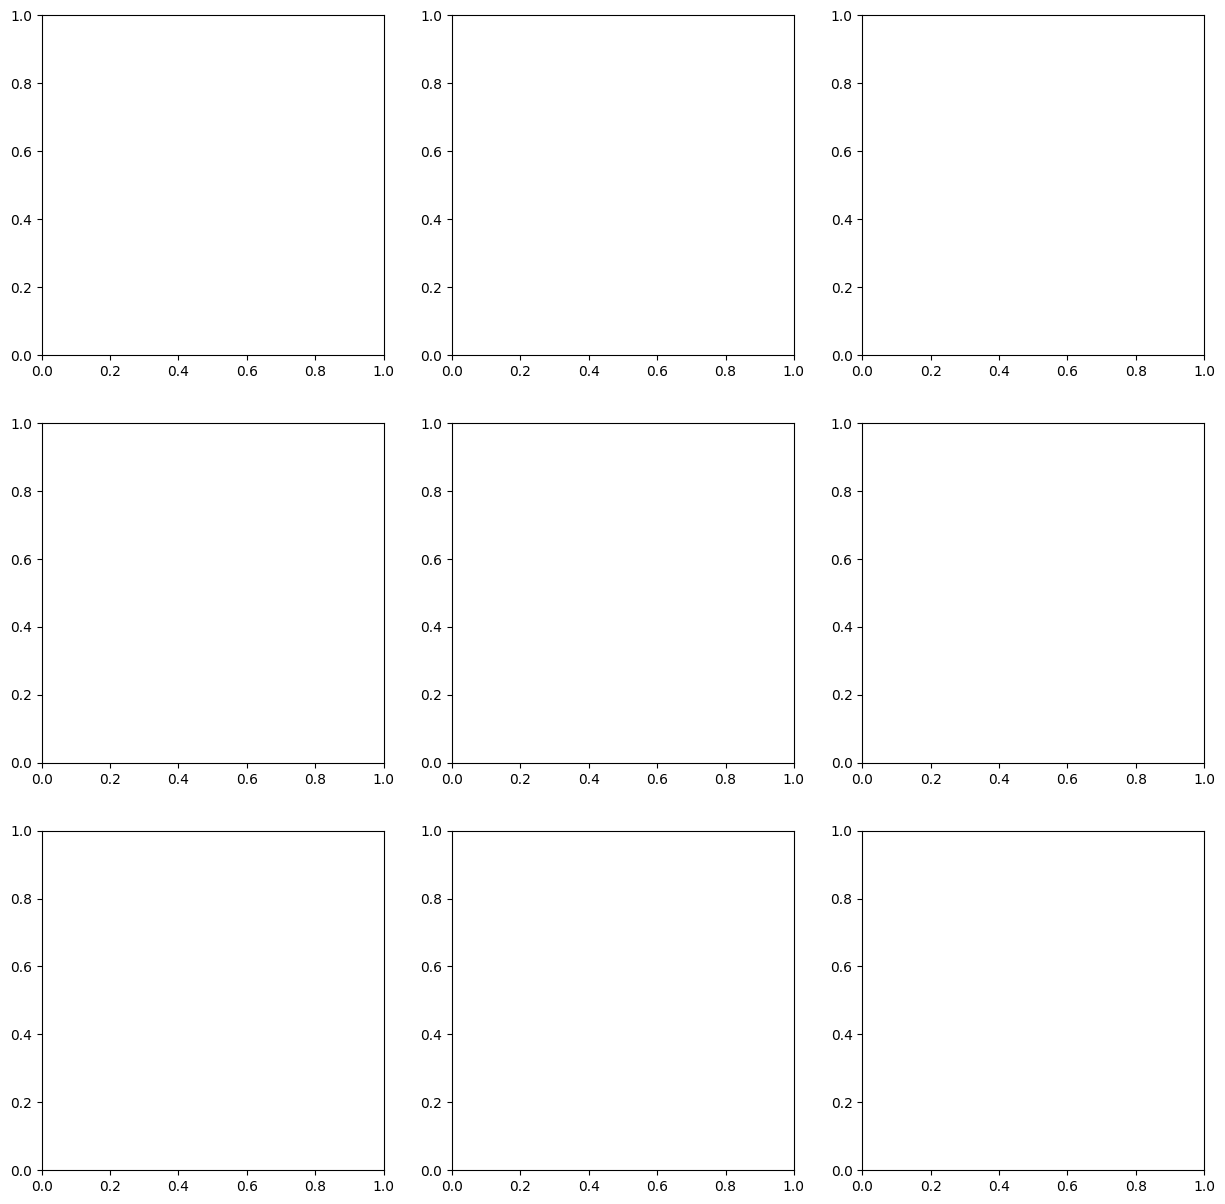

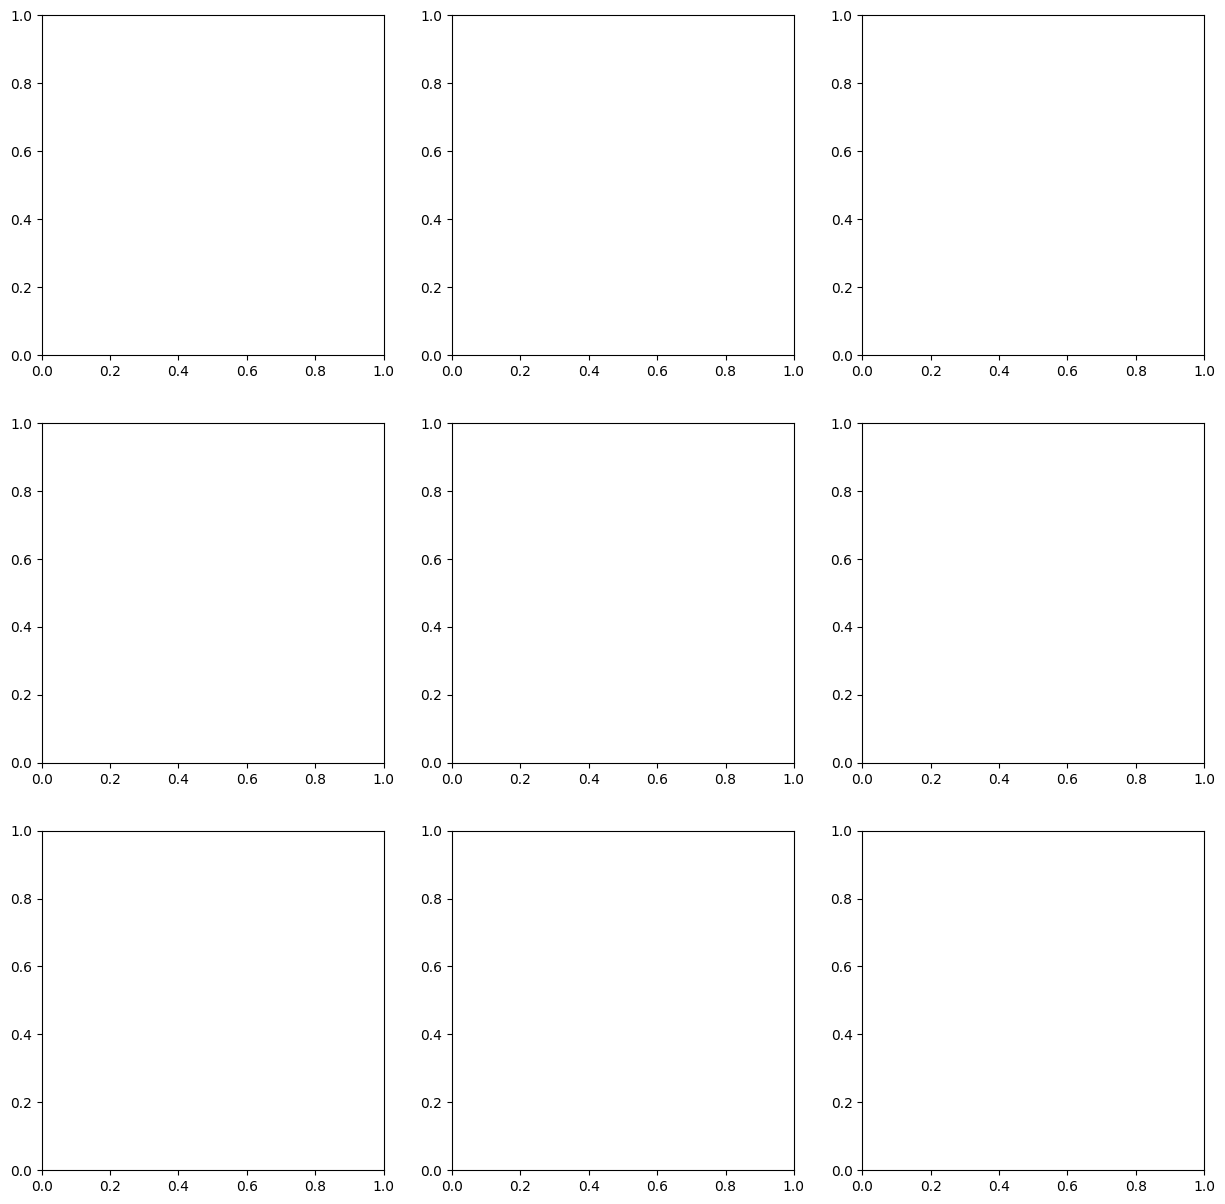

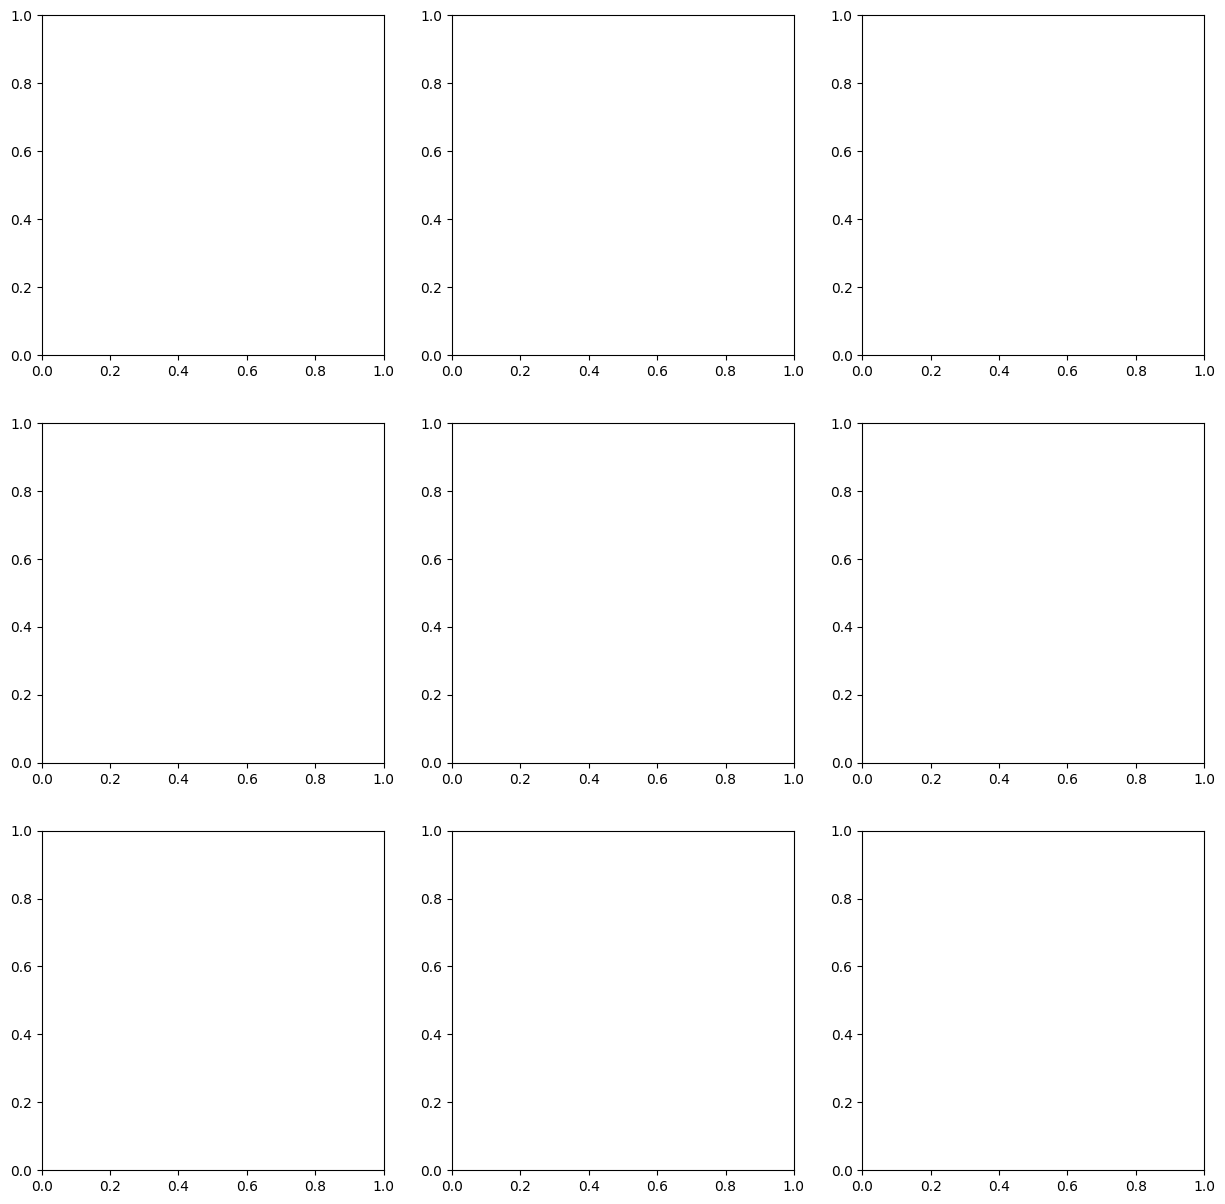

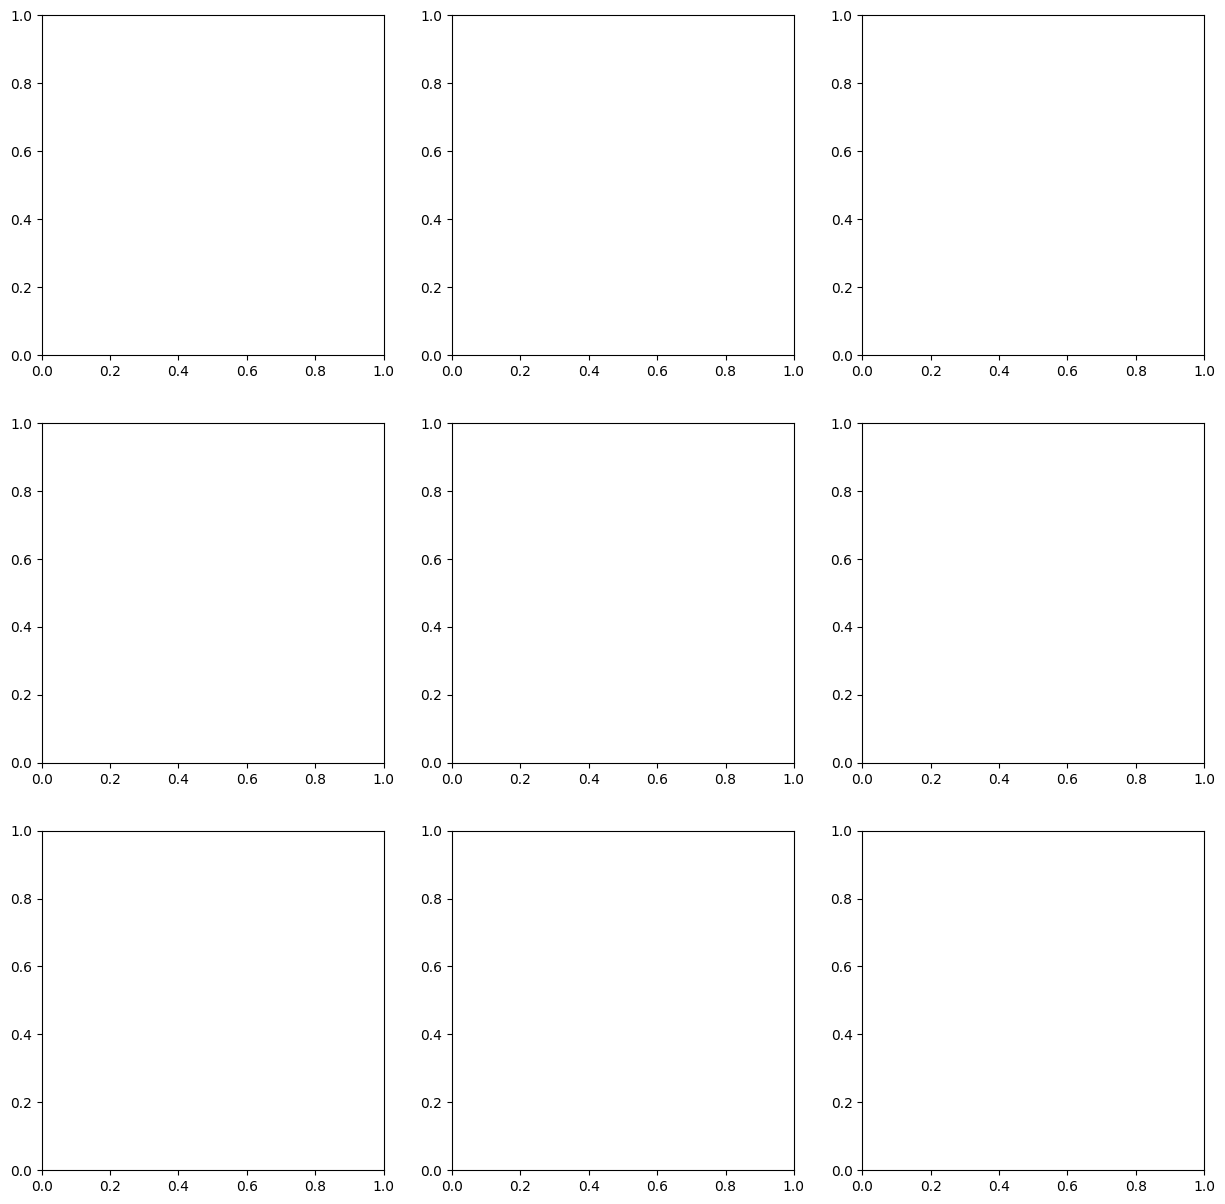

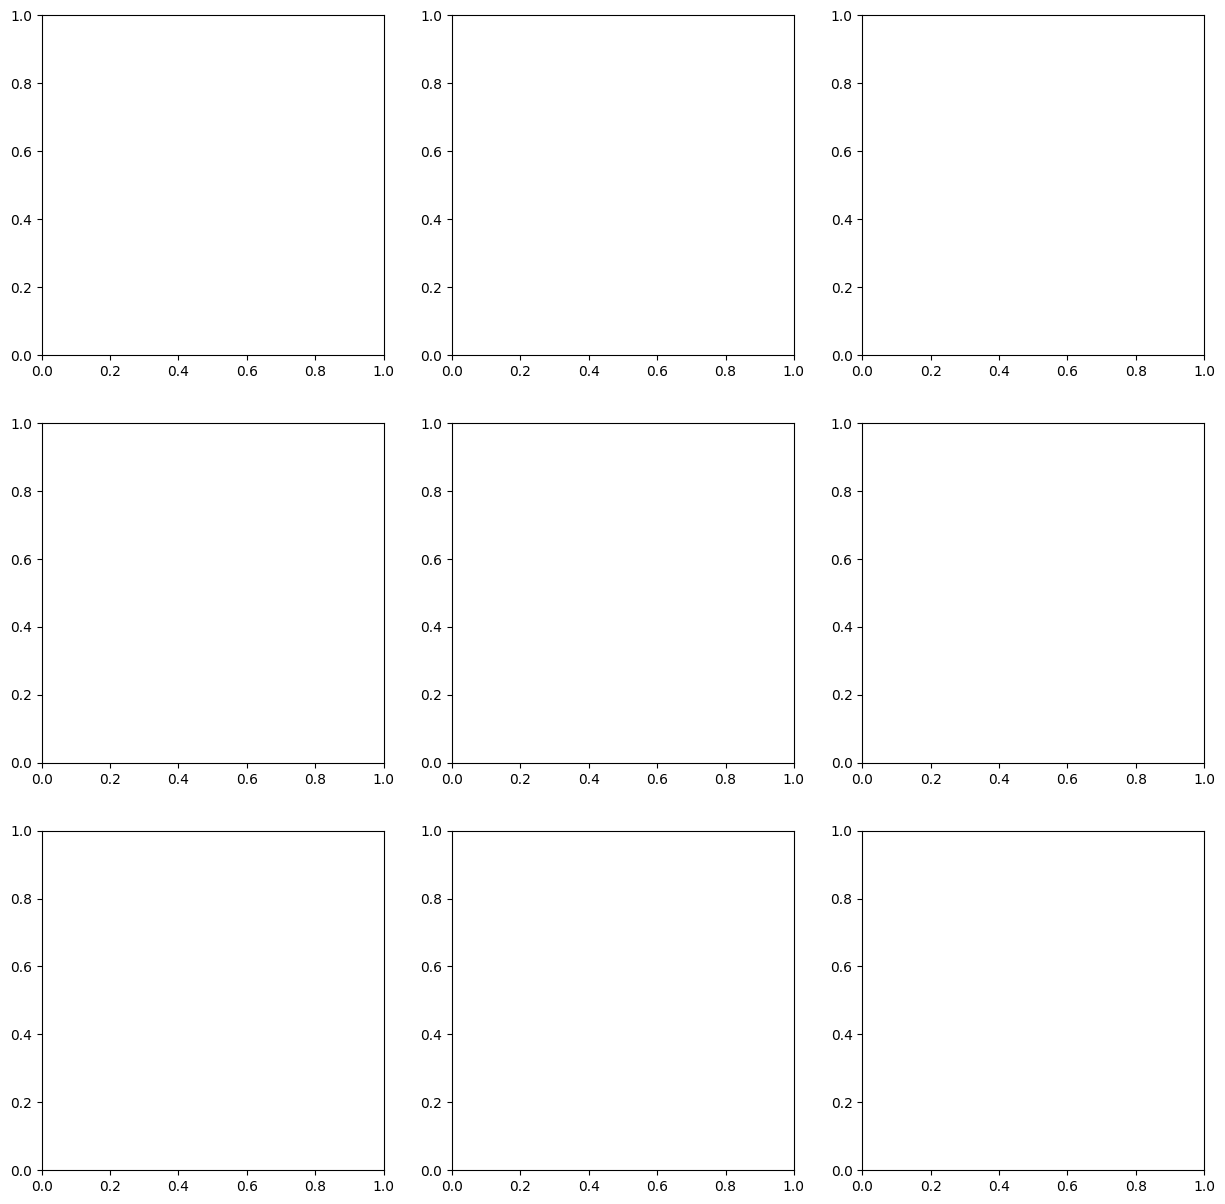

In [62]:
from concurrent.futures import ThreadPoolExecutor
import time

# Konfiguracja
EPOCHS = 10_000 #* 6000 epok / min
LR_CONSTANT = 5e-3
LR_RATIO = 1e-2 # LR_DYSKR / LR_GEN
BATCH_SIZE = 128
NOISE_SIZE = 256
GENERATOR_SAMPLES_TO_RETURN = 768

# for LR_RATIO in 10 ** np.linspace(-0.5, 0.5, num=4, endpoint=True):
torch.manual_seed(42)
np.random.seed(42)

x_kurtosis_history, y_kurtosis_history  = np.empty(EPOCHS), np.empty(EPOCHS)
x_skewness_history, y_skewness_history  = np.empty(EPOCHS), np.empty(EPOCHS)
x_stdev_history, y_stdev_history        = np.empty(EPOCHS), np.empty(EPOCHS)
x2_mean_history, y2_mean_history        = np.empty(EPOCHS), np.empty(EPOCHS)
generator_losses, discriminator_losses  = np.empty(EPOCHS), np.empty(EPOCHS)
KL, JSD, Wasserstein_distance           = np.empty(EPOCHS), np.empty(EPOCHS), np.empty(EPOCHS)
G_weight_change, D_weight_change        = np.empty(EPOCHS), np.empty(EPOCHS)
penalization = np.zeros(EPOCHS)

# transposed:  (Input_size - 1) × Stride - 2×Padding + Kernel_size + Output_padding
neuron_numbers = [NOISE_SIZE, 512, 256, 256, 256, 256, 512, GENERATOR_SAMPLES_TO_RETURN]
generator_layers = []
for n in neuron_numbers:
    generator_layers += [nn.LazyLinear(n), nn.BatchNorm1d(n), nn.Dropout(0.15)]

generator_layers.append(nn.LazyLinear(GENERATOR_SAMPLES_TO_RETURN))
generator = Generator(generator_layers, LR_CONSTANT)

# convolution: floor((Input_size + 2×Padding - Kernel_size) / Stride) + 1
neuron_numbers = [GENERATOR_SAMPLES_TO_RETURN, 1024, 256, 128, 64, 32, 16, 8, 4, 2, 1]
discriminator_layers = []
prev = neuron_numbers[0]
for n in neuron_numbers[1:-1]:
    discriminator_layers += [nn.Linear(prev, n), nn.LeakyReLU(0.2)]
    prev = n
discriminator_layers += [nn.LazyLinear(neuron_numbers[-1]), nn.Sigmoid()]

discriminator = Discriminator(discriminator_layers, LR_CONSTANT * LR_RATIO)

generator.train()
generator.compile()
discriminator.train()
discriminator.compile()


def add_stats(data_tensor: torch.Tensor, epoch):
    tensor_view = data_tensor.view(BATCH_SIZE, -1, 2)
    squared_mean = torch.pow(tensor_view, 2).mean(dim=1) # czy nie dolaczyc tego torch.catem ?

    if epoch is not None:
        means = tensor_view.mean(dim=1)  # (batch, 2)
        stds = tensor_view.std(dim=1)    # (batch, 2)

        normalized = (tensor_view - means.unsqueeze(1)) / stds.unsqueeze(1)

        skewness = torch.pow(normalized, 3).mean(dim=1)
        kurtosis = torch.pow(normalized, 4).mean(dim=1) - 3

        x_kurtosis_history[epoch],  y_kurtosis_history[epoch]   = kurtosis.mean(dim=0).cpu().numpy()
        x_skewness_history[epoch],  y_skewness_history[epoch]   = skewness.mean(dim=0).cpu().numpy()
        x2_mean_history[epoch],     y2_mean_history[epoch]      = squared_mean.mean(dim=0).cpu().numpy()
        x_stdev_history[epoch],     y_stdev_history[epoch]      = stds.mean(dim=0).cpu().numpy()


def gather_stats(true_data, fake_data, epoch):
    true_data_np = true_data.reshape(-1, 1).cpu().detach().numpy()
    fake_data_np = fake_data.reshape(-1, 1).cpu().detach().numpy()

    progress = epoch / EPOCHS
    filled = int(200 * progress)
    bar = '█' * filled + '░' * (200 - filled)
    print(f'\rTrening [{bar}] ({progress*100:5.1f}%)', end='', flush=True)

    KL[epoch], JSD[epoch] = fast_kl_jsd_2d(true_data_np, fake_data_np)
    Wasserstein_distance[epoch] = stats.wasserstein_distance(fake_data_np.reshape(-1,), true_data_np.reshape(-1,))

    if epoch % 1_000 == 0 and epoch != 0:
        plot_basic_stats(generator_losses, discriminator_losses, KL, JSD, Wasserstein_distance, epoch, f'\nTrening_dla_{LR_RATIO=}_{epoch=}')


def create_noise_and_data():
    noise = torch.randn(BATCH_SIZE, NOISE_SIZE, device='cuda')
    data = get_2d_data(BATCH_SIZE * GENERATOR_SAMPLES_TO_RETURN)
    return noise, data


def calculate_weights(model: nn.Module):
    total_norm = 0.0
    for parameter in model.parameters():
        if parameter.grad is not None: # kiedy mialoby byc None?
            total_norm += parameter.grad.norm(2).item() ** 2

    return total_norm ** 0.5


def add_weights(epoch: int):
    G_weight_change[epoch] = calculate_weights(generator)
    D_weight_change[epoch] = calculate_weights(discriminator)

"""
    cel: stale dla ktorych generator jest fatalny
"""

noise, data = create_noise_and_data()

start_time = time.time()
with ThreadPoolExecutor(max_workers=4) as executor: #* Potem zkompressuj i przyspiesz cala konstrukcje
    for epoch in range(EPOCHS):
        fake_data = generator.layers(noise).detach()
        
        add_stats(fake_data, epoch)

        transform_to_normal(fake_data)

        true_data = torch.FloatTensor(data).reshape(BATCH_SIZE, -1).cuda()

        transform_to_normal(true_data)

        discriminator_losses[epoch] = discriminator.training_step(true_data, fake_data)
        generator_losses[epoch] = generator.training_step(noise, true_data)
        
        future_stats = executor.submit(gather_stats, true_data, fake_data, epoch)
        future_weights = executor.submit(add_weights, epoch)
        noise, data = executor.submit(create_noise_and_data).result()

bar = '█' * 200
print(f'\rTrening [{bar}] {epoch:4d}/{EPOCHS}\n({100:5.1f}%)\n', end='', flush=True)
print(f'\n{EPOCHS / (time.time() - start_time) * 60:.0f} Epok / min')

plot_basic_stats(generator_losses, discriminator_losses, KL, JSD, Wasserstein_distance, EPOCHS, f'\nTrening_dla_{LR_RATIO=}')

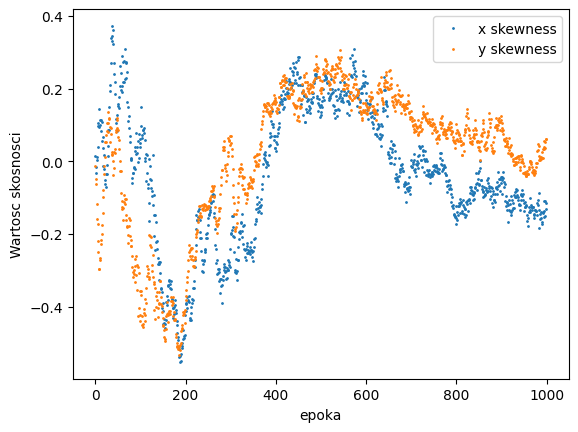

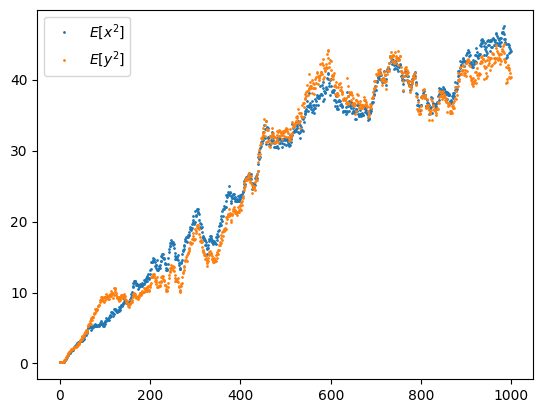

In [ ]:
plt.plot(x_skewness_history, 'o', markersize=1, label='x skewness')
plt.plot(y_skewness_history, 'o', markersize=1, label='y skewness')
plt.xlabel('epoka')
plt.ylabel('Wartosc skosnosci')
plt.legend()
plt.show()

plt.plot(x2_mean_history, 'o', markersize=1, label=r'$E[x^2]$')
plt.plot(y2_mean_history, 'o', markersize=1, label=r'$E[y^2]$')
plt.legend()

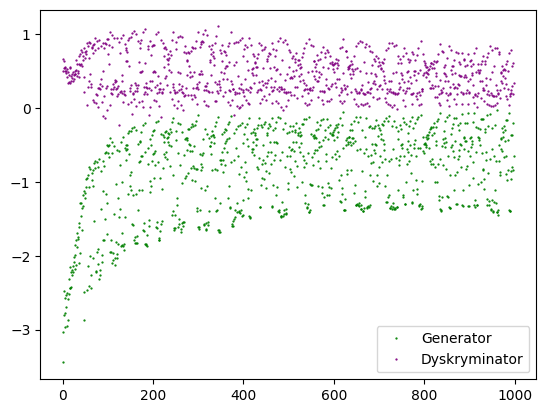

In [ ]:
plt.plot(np.log10( G_weight_change[:epoch] ), 'o', markersize=0.6, color='green', label='Generator')
plt.plot(np.log10( D_weight_change[:epoch] ), 'o', markersize=0.6, color='purple', label='Dyskryminator')
plt.legend()